In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
device = torch.device("cuda")
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

c:\Users\mackm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r'./final_train_data_music_queries.csv')

In [3]:
df.head(5)

,query,label
0,"I'm looking for some upbeat, rhythmic tracks t...",danceability
1,Can you suggest some songs that are perfect fo...,danceability
2,"I need a playlist for a dance class, something...",danceability
3,What are some good songs for a high-energy Zum...,danceability
4,I'm hosting a get-together and need music that...,danceability


In [4]:
df['label'].unique()

array(['danceability', 'valence', 'loudness', 'acousticness', 'tempo',
       'speechiness', 'low valence'], dtype=object)

In [5]:
df['label_encoded'] = pd.factorize(df['label'])[0]
df['label_encoded'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Getting sentence embeddings for all the queries - to make the information processable for a neural network.

Model of choice - sentence BERT - creates one embedding for a whole prompt. An embedding is a tensor size [384].

In [6]:
llm_model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
def encode_sentence(sentence):
    encoded_sentence = torch.from_numpy(llm_model.encode(sentence))
    return encoded_sentence

In [8]:
tqdm.pandas()
df['sentence_embeddings'] = df['query'].progress_apply(encode_sentence)

  0%|          | 0/35000 [00:00<?, ?it/s]

100%|██████████| 35000/35000 [06:21<00:00, 91.65it/s] 


In [11]:
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
# train - test - val split
df = df.sample(frac=1).reset_index(drop=True)
train_sample = df.sample(frac=0.7).reset_index(drop=True)
remaining = df.drop(train_sample.index).reset_index(drop=True)
val_sample = remaining.sample(frac=0.5).reset_index(drop=True)
test_sample = remaining.drop(val_sample.index).reset_index(drop=True)

In [13]:
df['sentence_embeddings'][0].dtype

torch.float32

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe['sentence_embeddings']
        self.labels = torch.tensor(dataframe['label_encoded'], dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [16]:
def train_loop(train_sample, model, optimizer, criterion, batch_size=512):
    running_loss = 0.0
    model.train()
    train_ds = CustomDataset(train_sample)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
        pbar.set_description(f"Training Loss: {running_loss / len(train_loader):.4f}")
    
    return running_loss / len(train_loader)

In [17]:
def validation_loop(val, model, criterion, batch_size=512):
    running_loss = 0.0
    model.eval()
    val_ds = CustomDataset(val)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print(f"Validation Loss: {running_loss / len(val_loader):.4f}")
    return running_loss / len(val_loader)

In [18]:
def train(model, train_sample, val_sample, criterion, optimizer, device, epochs):
    scores = []
    losses = []
    model.to(device)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
        epoch_losses = train_loop(train_sample, model, optimizer, criterion)
        epoch_scores = validation_loop(val_sample, model, criterion)

        # print(epoch_scores)
        scores.append(epoch_scores)
        losses.append(epoch_losses)

    pd.DataFrame({"train loss":losses}).plot(xlabel="step", ylabel="loss", style="-", title="Train")

    pd.DataFrame({'score': scores}).plot(xlabel="epoch", ylabel="score", style="o-", title="Validation")
    print("Done!")
    return model, epoch_losses

Epoch 1/5
-------------------------------


  0%|          | 0/48 [00:00<?, ?it/s]

Training Loss: 1.8294: 100%|██████████| 48/48 [00:00<00:00, 84.86it/s]


Validation Loss: 1.6256
Epoch 2/5
-------------------------------


Training Loss: 1.4037: 100%|██████████| 48/48 [00:00<00:00, 97.54it/s]


Validation Loss: 1.2561
Epoch 3/5
-------------------------------


Training Loss: 1.2151: 100%|██████████| 48/48 [00:00<00:00, 94.84it/s]


Validation Loss: 1.1921
Epoch 4/5
-------------------------------


Training Loss: 1.1833: 100%|██████████| 48/48 [00:00<00:00, 101.03it/s]


Validation Loss: 1.1776
Epoch 5/5
-------------------------------


Training Loss: 1.1747: 100%|██████████| 48/48 [00:00<00:00, 96.94it/s]


Validation Loss: 1.1725
Done!


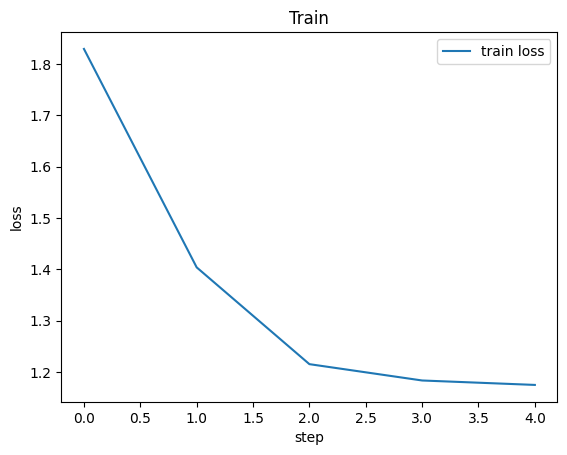

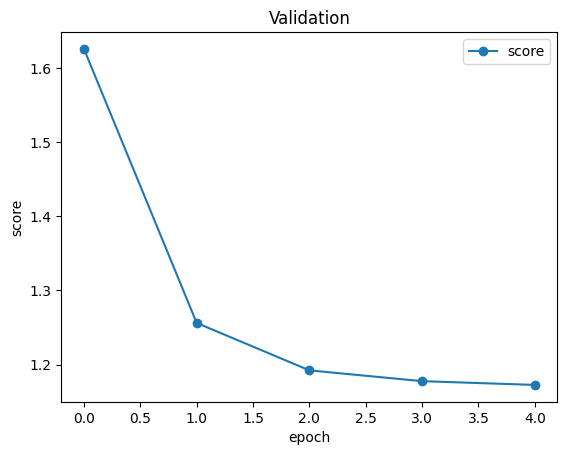

In [19]:
input_size = 384
hidden_size = 128
output_size =  df['label_encoded'].nunique()
model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
device = "cuda"

model, train_losses = train(model=model, train_sample=train_sample, val_sample=val_sample, criterion=criterion, optimizer=optimizer, device=device, epochs=epochs)

In [21]:
# some manual testing
# Assuming df['sentence_embeddings'][56] contains the tensor for prediction
i = 6421
input_tensor = df['sentence_embeddings'][i].to(device)

# Convert the input tensor to a format that the model expects
input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()  # Adding batch dimension and converting to float

# Ensure the model is in evaluation mode
model.eval()

# Perform the prediction
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class
_, predicted = torch.max(output, 1)

predicted_label = predicted.item()  # Convert tensor to a Python scalar
print(f"Predicted Label: {predicted_label}, actual label is {df['label_encoded'][i]}")
print(df['query'][i])

Predicted Label: 1, actual label is 1
I'm in search of songs that lift your spirits. Tracks that are full of positive energy and make you feel great.


C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\3078406266.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()  # Adding batch dimension and converting to float


In [22]:
df['label']

0            loudness
1             valence
2        acousticness
3         low valence
4               tempo
             ...     
34995    danceability
34996     speechiness
34997    acousticness
34998     low valence
34999     low valence
Name: label, Length: 35000, dtype: object

In [23]:
# once again, testing manually
c = 0
for i in range (5000):
    input_tensor = df['sentence_embeddings'][i].to(device)

    # Convert the input tensor to a format that the model expects
    input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()  # Adding batch dimension and converting to float

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the prediction
    with torch.no_grad():
        output = model(input_tensor)

    # Get the predicted class
    _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()  # Convert tensor to a Python scalar
    if predicted_label == df['label_encoded'][i] and predicted_label != 0:
        c += 1
c

C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\974975448.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()  # Adding batch dimension and converting to float


4298

In [24]:
# testing on prompts not related with music
sentence = "i am a programmer with 7 years of eperience"
emb = encode_sentence(sentence)
input_tensor = emb.to(device)
input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
model.eval()

with torch.no_grad():
    output = model(input_tensor)

_, predicted = torch.max(output, 1)

predicted_label = predicted.item()

label_encoding = df.iloc[predicted_label]['label_encoded']
label_encoding
torch.set_printoptions(sci_mode=False)
print(f'{output}, predicted label is {predicted_label} - {df.loc[df["label_encoded"] == predicted_label, "label"].iloc[0]}')

tensor([[0.3365, 0.3648, 0.0076, 0.0681, 0.0345, 0.0160, 0.1724]],
       device='cuda:0'), predicted label is 1 - valence


C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\538405393.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


In [33]:
def predict(sentence):
    emb = encode_sentence(sentence)
    input_tensor = emb.to(device)
    input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        output = output.cpu()

    _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()
    return predicted_label

In [34]:
# actual testing
test = pd.read_csv('./more_modified_music_queries_test_set.csv')

In [35]:
predict(test['query'][0])

C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\329741749.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


0

In [36]:
test

,query,label,label_encoded
0,suitable for a lively evening music needed. Al...,danceability,0
1,I'm looking for songs that are really powerful...,loudness,2
2,"for deeper thoughts music needed. Also, can yo...",low valence,6
3,"brightens the mood music needed. Also, i'm in ...",valence,1
4,"for a quick pace music needed. Also, gets the ...",tempo,4
...,...,...,...
14995,"dominates the room music needed. Also, looking...",loudness,2
14996,I'm in search of songs that lift your spirits....,valence,1
14997,"dominates the room music needed. Also, really ...",loudness,2
14998,I'm searching for music where the lyrics and v...,speechiness,5


In [37]:
predicted_labels = []
actual_labels = test['label_encoded']

for sentence in tqdm(test['query']):
    pred = predict(sentence)
    predicted_labels.append(pred)

  0%|          | 0/15000 [00:00<?, ?it/s]C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\329741749.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
100%|██████████| 15000/15000 [02:55<00:00, 85.53it/s] 


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate Precision (you might need to adjust the average parameter if dealing with multiclass)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(actual_labels, predicted_labels, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')
print("F1-score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9821333333333333
Precision: 0.9841193419051569
Recall: 0.9821333333333333
F1-score: 0.9823135047197545
Confusion Matrix:
 [[2143    0    0    0    0    0    0]
 [   2 2141    0    0    0    0    0]
 [  73    0 2070    0    0    0    0]
 [   0    0    0 2142    0    0    0]
 [ 193    0    0    0 1950    0    0]
 [   0    0    0    0    0 2143    0]
 [   0    0    0    0    0    0 2143]]


Some label info

In [39]:
unique_values = sorted(df['label_encoded'].unique())

for i in range(min(unique_values), max(unique_values) + 1):
    if i in unique_values:
        label_meaning = df.loc[df['label_encoded'] == i, 'label'].iloc[0]
        print(f"{i} means {label_meaning}")

0 means danceability
1 means valence
2 means loudness
3 means acousticness
4 means tempo
5 means speechiness
6 means low valence


In [ ]:
# torch.save(model, './label_model.pt')

Now once the model is done, let's give it a go on the songs data.

For the purpose of giving well-known recommendations, only the songs of top 5k artists on Spotify will be given.

In [55]:
songs = pd.read_csv('./resources/278k songs labeled/TEST_labeled_songs_with_name.csv')
songs = songs[songs['instrumentalness'] < 0.6]
songs = songs[songs['tempo'] < 130]
songs = songs[songs['liveness'] < 0.8]
top_artists = pd.read_csv('./top10k-spotify-artist-metadata.csv')
user_item = pd.read_csv("./resources/archive/jams.csv", delimiter='\t', on_bad_lines='skip')

sorted_by10k = user_item[user_item['artist'].isin(top_artists['artist'][:5000])]
songs = songs[songs['uri'].isin(sorted_by10k['spotify_uri'])]
songs['low_valence'] = 1 - songs['valence']
songs = songs.drop(columns=['Unnamed: 0.1',	'Unnamed: 0', 'duration (ms)', 'energy', 'instrumentalness', 'liveness', 'spec_rate'])

In [56]:
column_order = ['danceability', 'valence', 'loudness', 'acousticness', 'tempo', 'speechiness', 'low_valence', 'labels', 'uri', 'url']
songs = songs[column_order]
songs = songs.reset_index()
songs

,index,danceability,valence,loudness,acousticness,tempo,speechiness,low_valence,labels,uri,url
0,60,0.476,0.159,-6.602,0.00397,127.934,0.0515,0.841,2,spotify:track:4WUduEPZZG6wiE9B5IklnY,https://open.spotify.com/track/4WUduEPZZG6wiE9...
1,71,0.717,0.464,-4.514,0.05950,111.472,0.0256,0.536,1,spotify:track:3Sz51kDvFhngNDinn8WRb5,https://open.spotify.com/track/3Sz51kDvFhngNDi...
2,85,0.627,0.763,-7.410,0.13300,85.999,0.0305,0.237,1,spotify:track:7iOyMOxdOULvXqUqC26spJ,https://open.spotify.com/track/7iOyMOxdOULvXqU...
3,105,0.719,0.625,-3.951,0.00683,124.963,0.0395,0.375,1,spotify:track:7z73ehYAn9O1XP9XlCqVtd,https://open.spotify.com/track/7z73ehYAn9O1XP9...
4,144,0.874,0.585,-5.667,0.02830,106.021,0.0315,0.415,1,spotify:track:0Bi1amRigSOIzLc21hOH6p,https://open.spotify.com/track/0Bi1amRigSOIzLc...
...,...,...,...,...,...,...,...,...,...,...,...
2266,277920,0.573,0.668,-5.954,0.22800,81.952,0.0562,0.332,1,spotify:track:3WBWgjyg6ew1Bq2sehB4is,https://open.spotify.com/track/3WBWgjyg6ew1Bq2...
2267,277925,0.619,0.709,-9.414,0.00388,115.043,0.0525,0.291,2,spotify:track:0F0MA0ns8oXwGw66B2BSXm,https://open.spotify.com/track/0F0MA0ns8oXwGw6...
2268,277926,0.491,0.472,-7.106,0.25000,119.250,0.0392,0.528,1,spotify:track:77NNZQSqzLNqh2A9JhLRkg,https://open.spotify.com/track/77NNZQSqzLNqh2A...
2269,277929,0.671,0.732,-18.064,0.25700,92.718,0.0323,0.268,1,spotify:track:2374M0fQpWi3dLnB54qaLX,https://open.spotify.com/track/2374M0fQpWi3dLn...


In [57]:
# let's normalize the dataset
songs['tempo'] = (songs['tempo'] - songs['tempo'].min()) / (songs['tempo'].max() - songs['tempo'].min())
songs['loudness'] = (songs['loudness'] - songs['loudness'].min()) / (songs['loudness'].max() - songs['loudness'].min())
songs['loudness'] = songs['loudness'] - songs['loudness'].min()
songs

,index,danceability,valence,loudness,acousticness,tempo,speechiness,low_valence,labels,uri,url
0,60,0.476,0.159,0.743193,0.00397,0.977997,0.0515,0.841,2,spotify:track:4WUduEPZZG6wiE9B5IklnY,https://open.spotify.com/track/4WUduEPZZG6wiE9...
1,71,0.717,0.464,0.822480,0.05950,0.802339,0.0256,0.536,1,spotify:track:3Sz51kDvFhngNDinn8WRb5,https://open.spotify.com/track/3Sz51kDvFhngNDi...
2,85,0.627,0.763,0.712512,0.13300,0.530528,0.0305,0.237,1,spotify:track:7iOyMOxdOULvXqUqC26spJ,https://open.spotify.com/track/7iOyMOxdOULvXqU...
3,105,0.719,0.625,0.843858,0.00683,0.946295,0.0395,0.375,1,spotify:track:7z73ehYAn9O1XP9XlCqVtd,https://open.spotify.com/track/7z73ehYAn9O1XP9...
4,144,0.874,0.585,0.778698,0.02830,0.744174,0.0315,0.415,1,spotify:track:0Bi1amRigSOIzLc21hOH6p,https://open.spotify.com/track/0Bi1amRigSOIzLc...
...,...,...,...,...,...,...,...,...,...,...,...
2266,277920,0.573,0.668,0.767800,0.22800,0.487345,0.0562,0.332,1,spotify:track:3WBWgjyg6ew1Bq2sehB4is,https://open.spotify.com/track/3WBWgjyg6ew1Bq2...
2267,277925,0.619,0.709,0.636415,0.00388,0.840443,0.0525,0.291,2,spotify:track:0F0MA0ns8oXwGw66B2BSXm,https://open.spotify.com/track/0F0MA0ns8oXwGw6...
2268,277926,0.491,0.472,0.724055,0.25000,0.885334,0.0392,0.528,1,spotify:track:77NNZQSqzLNqh2A9JhLRkg,https://open.spotify.com/track/77NNZQSqzLNqh2A...
2269,277929,0.671,0.732,0.307955,0.25700,0.602224,0.0323,0.268,1,spotify:track:2374M0fQpWi3dLnB54qaLX,https://open.spotify.com/track/2374M0fQpWi3dLn...


In [58]:
label_cols = ['danceability', 'valence', 'loudness', 'acousticness', 'tempo', 'speechiness', 'low_valence']
songs['song_labels'] = songs.apply(lambda row: np.array(row[label_cols]), axis=1)
songs.head(5)

,index,danceability,valence,loudness,acousticness,tempo,speechiness,low_valence,labels,uri,url,song_labels
0,60,0.476,0.159,0.743193,0.00397,0.977997,0.0515,0.841,2,spotify:track:4WUduEPZZG6wiE9B5IklnY,https://open.spotify.com/track/4WUduEPZZG6wiE9...,"[0.476, 0.159, 0.7431934687677995, 0.00397, 0...."
1,71,0.717,0.464,0.822480,0.05950,0.802339,0.0256,0.536,1,spotify:track:3Sz51kDvFhngNDinn8WRb5,https://open.spotify.com/track/3Sz51kDvFhngNDi...,"[0.717, 0.464, 0.8224795898993734, 0.0595, 0.8..."
2,85,0.627,0.763,0.712512,0.13300,0.530528,0.0305,0.237,1,spotify:track:7iOyMOxdOULvXqUqC26spJ,https://open.spotify.com/track/7iOyMOxdOULvXqU...,"[0.627, 0.763, 0.7125118663375736, 0.133, 0.53..."
3,105,0.719,0.625,0.843858,0.00683,0.946295,0.0395,0.375,1,spotify:track:7z73ehYAn9O1XP9XlCqVtd,https://open.spotify.com/track/7z73ehYAn9O1XP9...,"[0.719, 0.625, 0.8438579836719194, 0.00683, 0...."
4,144,0.874,0.585,0.778698,0.02830,0.744174,0.0315,0.415,1,spotify:track:0Bi1amRigSOIzLc21hOH6p,https://open.spotify.com/track/0Bi1amRigSOIzLc...,"[0.874, 0.585, 0.7786975507879247, 0.0283, 0.7..."


In [62]:
def give_10_songs(sentence):
    scores = []
    recommendations = []
    emb = encode_sentence(sentence)
    input_tensor = emb.to(device)
    input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
    
    output = output.cpu().numpy()
    
    for label in songs['song_labels']:
        # label = np.delete(label, 2)
        dist = np.linalg.norm(label - output)
        # cos_sim = spatial.distance.cosine(output, label)
        scores.append(dist)
    
    for i in range(len(scores)):
        recommendations.append(songs['url'][i])
    
    pairs = list(zip(recommendations, scores))
    sorted_pairs = sorted(pairs, key=lambda x: x[1])
    sorted_recommendations = [pair[0] for pair in sorted_pairs]

    return sorted_recommendations[:10], output

In [64]:
# let's do a Lüscher test output prediction
luscher = """Tries to escape from his problems, difficulties and tensions by abrupt, headstrong and ill-considered decisions or changes of direction.
Defensive. Feels his position is threatened or inadequately established. Determined to pursue his objectives despite the anxiety induced by opposition.
Physiological interpretation: Suppressed agitation resulting from unsatisfactory or discordant personal relationships. Can lead to irritability, angry outbursts or sexual neuroses. There is a possibility of cardiac complaints.
Psychological interpretation: Considerable distress is arising from some unsatisfactory relationship. He feels helpless to restore affinity and any semblance of mutual trust, so the situation is regarded as a depressing and unhappy state which he must continue to tolerate. Beset to the point of nervous prostration.
In brief: Helpless and irritable disharmony.
Physiological interpretation: Stress resulting from frustration in his attempts to achieve security and understanding.
Psychological interpretation: Is responsive to outside stimuli and wants to experience everything intensely, but is finding the existing situation extremely frustrating. Needs sympathetic understanding and a sense of security. Distressed by his apparent powerlessness to achieve his goals.
In brief: Frustrated empathy."""
predict(luscher)

C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\329741749.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


6

In [65]:
input, output = give_10_songs(luscher)
for i, uri in enumerate(input, 1):
        print(f"{i}. {uri}")
np.set_printoptions(suppress = True)
print(len(input))

1. https://open.spotify.com/track/48xNw8YZxvrc3qB5IKaJ8w
2. https://open.spotify.com/track/5BOMJwJhP84KsMLCqmTUYD
3. https://open.spotify.com/track/4uWjXFthU2ts7QfKZDWuwR
4. https://open.spotify.com/track/1ZqHjApl3pfzwjweTfMi0g
5. https://open.spotify.com/track/356dWMVMXLJI6OEoq0ITf1
6. https://open.spotify.com/track/5XDUR6VWpCtgv2hYH5GdMB
7. https://open.spotify.com/track/1IhnbJZ7FywEL7YCyLKDgv
8. https://open.spotify.com/track/0gEyKnHvgkrkBM6fbeHdwK
9. https://open.spotify.com/track/1y3r6RXiJZNBV1EI0NggpS
10. https://open.spotify.com/track/4lKWSv9JLE8B1YINRFv42O
10


C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\1509136889.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


In [63]:
# some generic prompt
input, output = give_10_songs("""sad music""")
for i, uri in enumerate(input, 1):
        print(f"{i}. {uri}")
np.set_printoptions(suppress = True)
print(len(input))

1. https://open.spotify.com/track/48xNw8YZxvrc3qB5IKaJ8w
2. https://open.spotify.com/track/5BOMJwJhP84KsMLCqmTUYD
3. https://open.spotify.com/track/4uWjXFthU2ts7QfKZDWuwR
4. https://open.spotify.com/track/1ZqHjApl3pfzwjweTfMi0g
5. https://open.spotify.com/track/356dWMVMXLJI6OEoq0ITf1
6. https://open.spotify.com/track/5XDUR6VWpCtgv2hYH5GdMB
7. https://open.spotify.com/track/1IhnbJZ7FywEL7YCyLKDgv
8. https://open.spotify.com/track/0gEyKnHvgkrkBM6fbeHdwK
9. https://open.spotify.com/track/1y3r6RXiJZNBV1EI0NggpS
10. https://open.spotify.com/track/5VwKEmrYEN5eAPvWqrrKS2
10


C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\1509136889.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


In [66]:
input, output = give_10_songs("""acoustic music""")
for i, uri in enumerate(input, 1):
        print(f"{i}. {uri}")
np.set_printoptions(suppress = True)
print(len(input))

1. https://open.spotify.com/track/5QnCtH7euld6R68UwcWrte
2. https://open.spotify.com/track/1oDCK7PW72XEZ1pE5rh87A
3. https://open.spotify.com/track/4FylEaO7ZcbRNLhRairniu
4. https://open.spotify.com/track/4YPYFUATiul0877A1HhSlW
5. https://open.spotify.com/track/7hK9jnESeCfc5fIHH76jKh
6. https://open.spotify.com/track/7a8FwfEPX4fPZjB8JytSWG
7. https://open.spotify.com/track/4ffRlxNL1gLrvirFvWFQPX
8. https://open.spotify.com/track/0dG69tIjOO6DSltDSINNOJ
9. https://open.spotify.com/track/1ltSMXmvwdwnHcVY6tXKnB
10. https://open.spotify.com/track/0wXiC2Qisd4DeehG8u6qqa
10


C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\1509136889.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()


Just a code to get a vector size [all songs]

In [67]:
def give_all_songs(sentence):
    scores = []
    recommendations = []
    emb = encode_sentence(sentence)
    input_tensor = emb.to(device)
    input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
    
    output = output.cpu().numpy()
    
    for label in songs['song_labels']:
        dist = np.linalg.norm(label - output)
        scores.append(dist)
    
    for i in range(len(scores)):
        recommendations.append(songs['uri'][i])
    
    pairs = list(zip(recommendations, scores))
    sorted_pairs = sorted(pairs, key=lambda x: x[1])
    sorted_recommendations = [pair[0] for pair in sorted_pairs]

    return sorted_recommendations, output

In [68]:
search_vector = give_all_songs('sad music')

C:\Users\mackm\AppData\Local\Temp\ipykernel_12848\4008017233.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor).unsqueeze(0).float()
